In [1]:
import sys, os, os.path, time
import argparse
import numpy
import torch
import torch.nn as nn
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.autograd import Variable
from Net_mModal import Net, NewNet, TransformerEncoder, Transformer, MMTEncoder, LateFusion, videoModel, SuperLateFusion
from util_in_multi_h5_unnorm import *
from util_out import *
from util_f1 import *
from AudioResNet import resnet50
# from AST import ASTModel
from ast_models_original import ASTModel
%matplotlib inline

import matplotlib.pyplot as plt


In [2]:
try:
    from torch.utils.tensorboard import SummaryWriter
except:
    from tensorboardX import SummaryWriter
#from transformers import  AdamW, get_linear_schedule_with_warmup
torch.backends.cudnn.benchmark = True
from torch.optim.lr_scheduler import LambdaLR

In [3]:
torch.cuda.is_available()
torch.cuda.device_count()

4

# VICTIM MODEL

In [4]:
parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)

parser.add_argument("--model_type", type=str, default='ast', help="the model used")
parser.add_argument("--dataset", type=str, default="audioset", help="the dataset used", choices=["audioset","audioset_s", "esc50", "speechcommands"])
parser.add_argument("--n_mels", type=int, default=128, help="number of mel bins")
parser.add_argument("--dataset-portion", type=str, default='full', help="balance set or full set")

parser.add_argument("--exp-dir", type=str, default="", help="directory to dump experiments")
parser.add_argument('--lr', '--learning-rate', default="0.001", type=str, metavar='LR', help='initial learning rate')
parser.add_argument("--optim", type=str, default="adam", help="training optimizer", choices=["sgd", "adam"])
parser.add_argument('-b', '--batch-size', default=12, type=int, metavar='N', help='mini-batch size')
parser.add_argument('-w', '--num-workers', default=32, type=int, metavar='NW', help='# of workers for dataloading (default: 32)')
parser.add_argument("--n-epochs", type=int, default=1, help="number of maximum training epochs")
# not used in the formal experiments
parser.add_argument("--lr_patience", type=int, default=2, help="how many epoch to wait to reduce lr if mAP doesn't improve")

parser.add_argument("--n-print-steps", type=int, default=100, help="number of steps to print statistics")

parser.add_argument('--freqm', help='frequency mask max length', type=int, default=0)
parser.add_argument('--timem', help='time mask max length', type=int, default=0)
parser.add_argument("--mixup", type=float, default=0, help="how many (0-1) samples need to be mixup during training")
parser.add_argument("--bal", type=str, default=None, help="use balanced sampling or not")
# the stride used in patch spliting, e.g., for patch size 16*16, a stride of 16 means no overlapping, a stride of 10 means overlap of 6.
parser.add_argument("--fstride", type=int, default=10, help="soft split freq stride, overlap=patch_size-stride")
parser.add_argument("--tstride", type=int, default=10, help="soft split time stride, overlap=patch_size-stride")
parser.add_argument('--imagenet_pretrain', help='if use ImageNet pretrained audio spectrogram transformer model', type=bool, default='True')
parser.add_argument('--audioset_pretrain', help='if use ImageNet and audioset pretrained audio spectrogram transformer model', type=bool, default='False')
parser.add_argument('--suffix', type=str, default='')

args = parser.parse_args(args=['--model_type=AST','--dataset=audioset_s','--batch-size=224', '--lr=1e-5','--suffix=ast_debug_m-27v37-37.05'])

In [5]:
exp_id = f"{args.dataset}-{args.dataset_portion}-f{args.fstride}-t{args.tstride}-p{args.imagenet_pretrain}-b{args.batch_size}-lr{args.lr}-{args.suffix}"
print(exp_id)

audioset_s-full-f10-t10-pTrue-b224-lr1e-5-ast_debug_m-27v37-37.05


In [6]:
WORKSPACE = '/jet/home/billyli/data_folder/AllaboutAudioSet/egs/audioset/exp'
MODEL_FILE = os.path.join(WORKSPACE, exp_id, 'models', 'audio_model.3.pth')

In [7]:
print(MODEL_FILE)

/jet/home/billyli/data_folder/AllaboutAudioSet/egs/audioset/exp/audioset_s-full-f10-t10-pTrue-b224-lr1e-5-ast_debug_m-27v37-37.05/models/audio_model.3.pth


In [8]:
# Load model
#model = Net(args).cuda()
if args.model_type == 'TAL':
    model = Net(args).cuda()
elif args.model_type == 'TAL-trans':
    model = TransformerEncoder(args).cuda()
elif args.model_type == 'TAL-new':
    model = NewNet(args).cuda()
elif args.model_type == 'Trans':
    model = Transformer(args).cuda()
elif args.model_type == 'resnet':
    model = resnet50().cuda()
elif args.model_type == 'MMT':
    model = MMTEncoder(args).cuda()
elif args.model_type == 'VM':
    model = videoModel(args).cuda()
elif args.model_type == 'MMTLF':
    model = LateFusion(args).cuda()
elif args.model_type == 'AST':
    model = ASTModel(label_dim=527, input_fdim=64, input_tdim=400, imagenet_pretrain=False, audioset_pretrain=False).cuda()
else:
    print ('model type not recognized')
    exit(0)


---------------AST Model Summary---------------
ImageNet pretraining: False, AudioSet pretraining: False
input_fdim: 64,input_tdim: 400
out_shape: torch.Size([1, 768, 5, 39])
f_dim: 5,t_dim: 39, num_patches: 195
frequncey stride=10, time stride=10
number of patches=195


In [9]:
optimizer = Adam(model.parameters())


In [10]:
print(prev_ckpt.keys())

NameError: name 'prev_ckpt' is not defined

In [11]:
prev_ckpt = torch.load(MODEL_FILE)
# start_ckpt = prev_ckpt['epoch']
# scheduler.load_state_dict(prev_ckpt['scheduler'])
model = nn.DataParallel(model)
model.load_state_dict(prev_ckpt)
# optimizer.load_state_dict(prev_ckpt['optimizer'])
# write_log('Loading model from %s' % args.continue_from_ckpt)
model.eval()

DataParallel(
  (module): ASTModel(
    (v): DistilledVisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (blocks): ModuleList(
        (0): Block(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=768, out_features=768, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (drop_path): Identity()
          (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (act): GELU()
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
            (drop): Dropout(p=0.0, inplace=False)

In [ ]:
gas_valid_x1, gas_valid_x2, gas_valid_y, gas_eval_hashes = multi_bulk_load('GAS_valid',args.normalize_scale)
gas_eval_x1, gas_eval_x2, gas_eval_y, gas_eval_hashes = multi_bulk_load('GAS_eval',args.normalize_scale)

# data pipeline

In [58]:
gas_eval_x1, gas_eval_x2, gas_eval_y, gas_eval_hashes = multi_bulk_load('GAS_eval', args.normalize_scale)

In [36]:
gas_eval_x1, gas_eval_y, gas_eval_hashes = bulk_load('GAS_eval', args.normalize_scale)

In [12]:
gas_eval_x1_origin, gas_eval_y, gas_eval_hashes = bulk_load('GAS_eval', 1.85)

In [13]:
gas_eval_x1_origin.shape

(20123, 400, 64)

In [13]:
min_val = numpy.min(gas_eval_x1_origin)
max_val = numpy.max(gas_eval_x1_origin)
mean_val = numpy.mean(gas_eval_x1_origin)
std_val = numpy.std(gas_eval_x1_origin)
print(min_val, max_val, mean_val, std_val)

-4.183053 1.4830612 -0.057615034 0.61040777


In [38]:
min_val = numpy.min(gas_eval_x1)
max_val = numpy.max(gas_eval_x1)
mean_val = numpy.mean(gas_eval_x1)
std_val = numpy.std(gas_eval_x1)
print(min_val, max_val, mean_val, std_val)

-0.96733105 0.3429579 -0.013323569 0.14115715


In [79]:
new_gas_eval = []

for record in gas_eval_x1:
    record=numpy.ma.array(record,mask=False)
    silence_val = numpy.min(record)
    count = 0
    for i in range(400):
        if i % 40 == 0:
            count +=1
        if count % 2 == 0:
            record.mask[i] = True
    mask_record = record.compressed().reshape(200,64)
    fill_matrix = numpy.full((200,64), silence_val)
#     print('shape', fill_matrix.shape)
    mask_record = numpy.vstack((mask_record, fill_matrix))
#     record.mask[100:300]=True
#     mask_record = record[~record.mask]
#     print(mask_record.shape)
#     mask_record = record.filled(fill_value=silence_val)
    new_gas_eval.append(mask_record)
new_gas_eval = numpy.array(new_gas_eval)

In [52]:
new_gas_eval = []

for record in gas_eval_x1:
    record=numpy.ma.array(record,mask=False)
    silence_val = numpy.min(record)
    count = 0
    for i in range(400):
        if i % 40 == 0:
            count +=1
        if count % 2 == 0:
            record.mask[i] = True
    mask_record = record.filled(fill_value=silence_val)
    new_gas_eval.append(mask_record)
new_gas_eval = numpy.array(new_gas_eval)

In [30]:
new_gas_eval = []

for record in gas_eval_x1:
    record=numpy.ma.array(record,mask=False)
    silence_val = numpy.min(record)
    record.mask[100:300]=True
    mask_record = record.filled(fill_value=silence_val)
    new_gas_eval.append(mask_record)
new_gas_eval = numpy.array(new_gas_eval)

In [107]:
print(new_gas_eval[55][:100])

[[0.47305003 0.4076682  0.50134546 ... 0.6356075  0.683082   0.8488398 ]
 [0.37092775 0.36121237 0.3622962  ... 0.87717116 0.95238364 0.9700665 ]
 [0.48785508 0.43535295 0.39470476 ... 1.0653913  1.1007261  1.0363234 ]
 ...
 [0.79046273 0.68853074 0.8537748  ... 1.2209055  1.2898538  1.3113441 ]
 [0.550083   0.6614824  0.7878561  ... 1.195247   1.0824723  1.1018984 ]
 [0.37332636 0.5803106  0.7480199  ... 0.9628182  0.9976649  1.2168456 ]]


In [25]:
arr = new_gas_eval[255].T

In [26]:
print(arr.shape)

(64, 400)


In [ ]:

plt.figure(figsize = (20,10))
plt.imshow(gas_eval_x1[1].T, origin='lower')
plt.savefig('imgs/hammer.png')
# plt.imshow(arr,interpolation='nearest', aspect='auto')
# plt.gca().invert_yaxis()


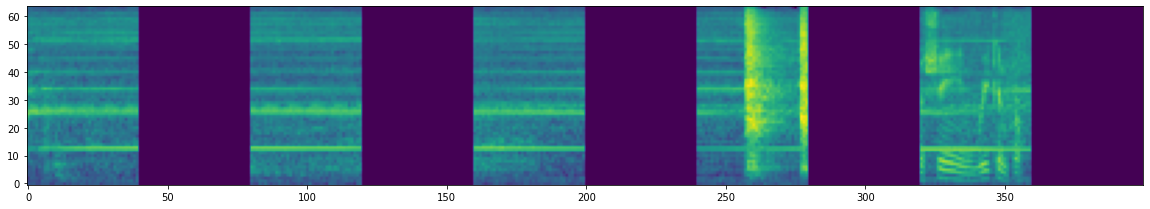

In [53]:
plt.figure(figsize = (20,10))

plt.imshow(new_gas_eval[1].T, origin='lower')
plt.savefig('imgs/0.5s-occlusion-concat.png')

In [40]:
arr=numpy.ma.array(arr,mask=False)
arr.mask[:200]=True

In [90]:
new_arr = arr.filled(fill_value=0)

In [91]:
print(new_arr[:200])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [14]:
result = []
batch_size =1000
x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
        output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        # att = output[2].cpu().numpy()
        # np.save('resnetatt.npy', att)
        # frame = output[1].cpu().numpy()
        # np.save('resnetframe.npy', frame)
        # exit(0)
#                 if not verbose: output = output[:1]
        result.append([output.data.cpu().numpy()])
print(len(result))
result = [numpy.concatenate(items) for items in zip(*result)]
print(len(result))
#     with torch.no_grad():
#     output = model.forward(torch.from_numpy(gas_eval_x1_origin))
#     output = torch.sigmoid(output)
# result_output = output.data.cpu().numpy()[0]

21
1


In [15]:
print(result[0].shape)

(20123, 527)


In [16]:
gas_eval_global_prob_multi = result[0]

In [54]:
gas_eval_global_prob_multi = model.module.predict(new_gas_eval, verbose=False)

202
1


In [72]:
print(gas_eval_global_prob_multi.shape)

(20123, 527)


In [18]:
print('Performance on Google Audio Set:')
print("   CLASS ||    AP |   AUC |    d' ")
FORMAT  = ' %00007s || %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)

Performance on Google Audio Set:
   CLASS ||    AP |   AUC |    d' 
---------++-------+-------+-------


In [19]:
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
for i in range(N_CLASSES):
    a, b, c = gas_eval(gas_eval_global_prob_multi[:,i], gas_eval_y[:,i])     # AP, AUC, dprime
    classwise_dict.append({'mAP':a, 'AUC':b, 'dprime':c, 'id':i})
    classwise.append((a, b, c))
map, mauc = numpy.array(classwise).mean(axis = 0)[:2]
print (map, mauc, dprime(mauc))
# for c in classwise_dict:
#     print(c)
print(FORMAT % ('Average', map, mauc, dprime(mauc)))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + classwise[i]))

0.3057548766832236 0.768261572061216 1.036807695528426
 Average || 0.306 | 0.768 | 1.037 
---------++-------+-------+-------
       0 || 0.837 | 0.891 | 1.739 
       1 || 0.095 | 0.361 |-0.504 
       2 || 0.069 | 0.482 |-0.064 
       3 || 0.299 | 0.722 | 0.833 
       4 || 0.166 | 0.783 | 1.106 
       5 || 0.099 | 0.675 | 0.642 
       6 || 0.332 | 0.904 | 1.848 
       7 || 0.376 | 0.856 | 1.504 
       8 || 0.091 | 0.509 | 0.031 
       9 || 0.079 | 0.622 | 0.438 
      10 || 0.087 | 0.703 | 0.754 
      11 || 0.139 | 0.733 | 0.879 
      12 || 0.789 | 0.988 | 3.185 
      13 || 0.451 | 0.942 | 2.223 
      14 || 0.268 | 0.783 | 1.107 
      15 || 0.695 | 0.934 | 2.134 
      16 || 0.371 | 0.802 | 1.200 
      17 || 0.416 | 0.926 | 2.050 
      18 || 0.155 | 0.785 | 1.115 
      19 || 0.157 | 0.763 | 1.012 
      20 || 0.306 | 0.905 | 1.856 
      21 || 0.179 | 0.736 | 0.893 
      22 || 0.310 | 0.840 | 1.408 
      23 || 0.409 | 0.882 | 1.677 
      24 || 0.144 | 0.745 | 0.930 


In [63]:
import matplotlib.pyplot as plt


<Figure size 28800x7200 with 0 Axes>

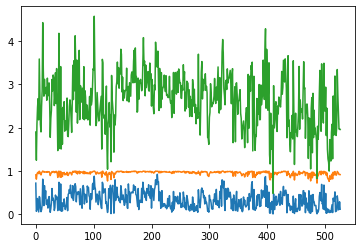

<Figure size 28800x7200 with 0 Axes>

In [64]:
plt.plot(classwise)
plt.figure(figsize=(400,100)) 


# Adversarial Routine

In [ ]:
for batch in range(1, args.ckpt_size + 1):
        x, y = next(train_gen)
        global_prob = model(x)[0]
        global_prob.clamp_(min = 1e-7, max = 1 - 1e-7)
        loss = criterion(global_prob, y)
        if args.gradient_accumulation > 1:
            loss = loss / args.gradient_accumulation
        #if n_gpu > 1:
        #    loss = loss.mean()
        train_loss += loss.item()
        if numpy.isnan(train_loss) or numpy.isinf(train_loss): break
        loss.backward()
        global_step += 1
        if global_step % args.gradient_accumulation == 0:
            optimizer.step()
            if args.scheduler == 'warmup-decay':
                scheduler.step() 
            optimizer.zero_grad()
        if batch % 500 == 0:
            sys.stderr.write('Checkpoint %d, Batch %d / %d, avg train loss = %f\r' % \
                            (checkpoint, batch, args.ckpt_size, train_loss / batch))
            tb_writer.add_scalar('lr', optimizer.param_groups[0]['lr'], global_step)
            tb_writer.add_scalar('loss', train_loss / batch, global_step)
            
        del x, y, global_prob, loss         # This line and next line: to save GPU memory
        torch.cuda.empty_cache()            # I don't know if they're useful or not
    train_loss /= args.ckpt_size


In [ ]:
def train(opt, model, adv_jam, trainloader, max_batches = 100):
    model.eval()
        
    batches = 0
    total = 0
    error = 0
    loss_ = 0.
    torch.manual_seed(0)

    for X_batch, y_batch in trainloader:
        # forward pass
        X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
        # plot(X_batch[0], y_batch[0])
        output = model(adv_jam(X))
        opt.zero_grad()
        neg_loss = -nn.CrossEntropyLoss()(output, y)

        neg_loss.backward()
        opt.step()



        # Evaluate performance
        adv_out = model(X_adv)
        adv_prediction = sigmoid(adv_out.squeeze().cpu().detach())>0.5
        adv_accuracy = (adv_prediction.numpy()==y_batch.cpu().numpy()).mean()
        print("Accuracy = {0}".format(adv_accuracy))
                # project into feasible region
        adv.jam.param1.clamp_(0,1)
        adv.jam.param2.clamp_(1, 40)
        adv.jam.param3.clamp_(0,224)
        total += X.shape[0]
        error += (output.max(1)[1] != y).sum().item()
        loss_ += nn.CrossEntropyLoss(size_average=False)(output, y).item()
            batches += 1
            if batches > max_batches:
                break

        return error / total, loss_ / total

In [1]:
def projected_gradient_descent(model, x, y, num_steps = 20, step_size = 0.1, step_norm=2, eps = 10, eps_norm=2,
                               clamp=(x_min, x_max), y_target=None):
    """Performs the projected gradient descent attack on a batch of images."""
    x_adv = x.clone().detach().requires_grad_(True)#.to(x.device)
    N, T, V = x.shape
    targeted = y_target is not None
    num_channels = x.shape[1]
    criterion = nn.BCELoss()

    for i in range(num_steps):
        _x_adv = x_adv.clone().detach().requires_grad_(True)
        
        out = model(_x_adv) # N x T x 1
        out_flatten = out.reshape(-1) 
        y_flatten = y.reshape(-1)
        loss = criterion(out_flatten, y_flatten)
        
        #prediction = model(_x_adv)
        #loss = criterion(prediction, y_target if targeted else y)
        loss.backward()

        with torch.no_grad():
            # Force the gradient step to be a fixed size in a certain norm
            if step_norm == 'inf':
                gradients = _x_adv.grad.sign() * step_size
            else:
                # The grad is normalized here.
                #gradients = _x_adv.grad 
                # Only normalize w.r.t. to feats at a timestep
                gradients = _x_adv.grad/_x_adv.grad.norm(step_norm, dim=-1).view(-1, T, 1)
                gradients *= step_size
                
            if targeted:
                # Targeted: Gradient descent with on the loss of the (incorrect) target label
                # w.r.t. the image data
                x_adv -= gradients
            else:
                # Untargeted: Gradient ascent on the loss of the correct label w.r.t.
                # the model parameters
                x_adv += gradients

        # Project back into l_norm ball and correct range
        if eps_norm == 'inf':
            # Workaround as PyTorch doesn't have elementwise clip
            x_adv = torch.max(torch.min(x_adv, x + eps), x - eps)
        else:
            delta = x_adv - x

            # Assume x and x_adv are batched tensors where the first dimension is
            # a batch dimension
            mask = delta.view(delta.shape[0], -1).norm(eps_norm, dim=1) <= eps

            scaling_factor = delta.view(delta.shape[0], T, -1).norm(eps_norm, dim=-1)
            scaling_factor[mask] = eps
            #print(scaling_factor.shape)
            # .view() assumes batched images as a 4D Tensor
            delta *= eps / scaling_factor.view(-1, T, 1)

            x_adv = x + delta
            
        x_adv = x_adv.clamp(*clamp)

    return x_adv.detach()

NameError: name 'x_min' is not defined